In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import scipy
import phate

from data.data_class import *
from utils.functionals import *
from utils.visualization import *
from utils.measures import MeasureAll

import trainers.trainers
import models.autoencoders


device = 'cpu'
random_seed = 21
torch.manual_seed(random_seed)
np.random.seed(random_seed)

# Swiss Roll

In [2]:
data_swissroll = SwissRoll(n_samples=10000, noise=0.0, test_size=0.85, random_state=21, hole=True)

In [3]:
X, y = data_swissroll.get_data(type='all')
X_train, y_train = data_swissroll.get_data(type='train')
X_test, y_test = data_swissroll.get_data(type='test')
GeoD, dist_list, indices = get_Distance_Mat(X_train, Geodesic=True, n_neighbors=5)

In [4]:
EPOCHS = 3000
DEVICE = 'cpu'

def train_BLAE(X_train, y_train, X_test, y_test):
    GeoD, dist_list, indices = get_Distance_Mat(X_train, Geodesic=True, n_neighbors=5)
    model = models.autoencoders.Autoencoder(input_dim=3, hidden_dim=256, latent_dim=2).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-3, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.1)
    trainer = trainers.trainers.GradientAutoencoderTrainer(
        optimizer=optimizer, scheduler=scheduler, reg_geo='InjectiveLoss', GeoD=GeoD,
        reg_grad='bi-lipschitz', lam_grad=0.3, lam_geo=1, L=1, device=DEVICE, thresh=0.3
    )
    trainer.get_dataloader(X_train, y_train, X_test, y_test, batch_size=X_train.shape[0]//3)
    trainer.train(model, epochs=EPOCHS, verbose=False)
    # visualizations(model.to('cpu'), X, y, method_name='BLAE', recon=True, connect=False)
    return model

def train_SPAE(X_train, y_train, X_test, y_test):
    GeoD, _, _ = get_Distance_Mat(X_train, Geodesic=True, n_neighbors=5)
    model = models.autoencoders.Autoencoder(input_dim=3, hidden_dim=256, latent_dim=2).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-3, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.1)
    trainer = trainers.trainers.GeodesicAutoencoderTrainer(
        regularization='SPAELoss', GeoD=GeoD, lam_geo=2, optimizer=optimizer, scheduler=scheduler, device=DEVICE
    )
    trainer.get_dataloader(X_train, y_train, X_test, y_test, batch_size=X_train.shape[0]//3)
    trainer.train(model, epochs=EPOCHS, verbose=False)
    # visualizations(model.to('cpu'), X, y, method_name='SPAE', recon=True, connect=False)
    return model

def train_DNAE(X_train, y_train, X_test, y_test):
    model = models.autoencoders.Autoencoder(input_dim=3, hidden_dim=256, latent_dim=2).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-3, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.1)
    trainer = trainers.trainers.DiffusionNetTrainer(
        lam=100, eta=0.001, n_neighbors=10, n_components=2, alpha=1,
        optimizer=optimizer, scheduler=scheduler, device=DEVICE
    )
    trainer.get_dataloader(X_train, y_train, X_test, y_test, batch_size=X_train.shape[0])
    trainer.fit(torch.tensor(X_train).float())
    trainer.train(model, epochs=EPOCHS, verbose=False)
    # visualizations(model.to('cpu'), X, y, method_name='DNAE', recon=True, connect=False)
    return model

def train_GGAE(X_train, y_train, X_test, y_test):
    GeoD_knn = compute_euclidean_knn_distance_matrix(X_train, k=10, limit=1e4)
    model = models.autoencoders.Autoencoder(input_dim=3, hidden_dim=256, latent_dim=2).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-3, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.1)
    trainer = trainers.trainers.GGAETrainer(
        lam=1, bandwidth=2, k=5, limit=1e4, global_dist=GeoD_knn,
        optimizer=optimizer, scheduler=scheduler, device=DEVICE
    )
    trainer.get_dataloader(X_train, y_train, X_test, y_test, batch_size=X_train.shape[0]//3)
    trainer.train(model, epochs=EPOCHS, verbose=False)
    # visualizations(model.to('cpu'), X, y, method_name='GGAE', recon=True, connect=False)
    return model

def train_GRAE(X_train, y_train, X_test, y_test):
    phate_operator = phate.PHATE(n_components=2, knn=5, t='auto', gamma=0.1, n_jobs=-1)
    X_reshaped = X_train.reshape(X_train.shape[0], -1)
    embedding = scipy.stats.zscore(phate_operator.fit_transform(X_reshaped))
    embedding = torch.tensor(embedding).float()
    model = models.autoencoders.Autoencoder(input_dim=3, hidden_dim=256, latent_dim=2).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-3, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.1)
    trainer = trainers.trainers.GRAETrainer(
        target_embedding=embedding, lam=100, optimizer=optimizer, scheduler=scheduler, device=DEVICE
    )
    trainer.get_dataloader(X_train, y_train, X_test, y_test, batch_size=X_train.shape[0]//3)
    trainer.train(model, epochs=EPOCHS, verbose=False)
    # visualizations(model.to('cpu'), X, y, method_name='GRAE', recon=True, connect=False)
    return model

def train_IRAE(X_train, y_train, X_test, y_test):
    model = models.autoencoders.Autoencoder(input_dim=3, hidden_dim=256, latent_dim=2).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-3, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.1)
    trainer = trainers.trainers.IRAETrainer(
        optimizer=optimizer, scheduler=scheduler, lambda_iso=0.01, eta=0., device=DEVICE
    )
    trainer.get_dataloader(X_train, y_train, X_test, y_test, batch_size=X_train.shape[0]//3)
    trainer.train(model, epochs=EPOCHS, verbose=False)
    # visualizations(model.to('cpu'), X, y, method_name='IRAE', recon=True, connect=False)
    return model

def train_GeomAE(X_train, y_train, X_test, y_test):
    GeoD, _, _ = get_Distance_Mat(X_train, Geodesic=True, n_neighbors=5)
    model = models.autoencoders.Autoencoder(input_dim=3, hidden_dim=256, latent_dim=2).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-3, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.1)
    trainer = trainers.trainers.GradientAutoencoderTrainer(
        reg_grad='geometric', GeoD=GeoD, lam_grad=0.01, optimizer=optimizer, scheduler=scheduler, device=DEVICE
    )
    trainer.get_dataloader(X_train, y_train, X_test, y_test, batch_size=X_train.shape[0]//3)
    trainer.train(model, epochs=EPOCHS, verbose=False)
    # visualizations(model.to('cpu'), X, y, method_name='GeomAE', recon=True, connect=False)
    return model

def train_GeomAE(X_train, y_train, X_test, y_test):
    GeoD, _, _ = get_Distance_Mat(X_train, Geodesic=True, n_neighbors=5)
    model = models.autoencoders.Autoencoder(input_dim=3, hidden_dim=256, latent_dim=2).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-3, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.1)
    trainer = trainers.trainers.GradientAutoencoderTrainer(
        reg_geo='InjectiveLoss', lam_geo=1,
        reg_grad='geometric', GeoD=GeoD, lam_grad=0.01, optimizer=optimizer, scheduler=scheduler, device=DEVICE
    )
    trainer.get_dataloader(X_train, y_train, X_test, y_test, batch_size=X_train.shape[0]//3)
    trainer.train(model, epochs=EPOCHS, verbose=False)
    # visualizations(model.to('cpu'), X, y, method_name='GeomAE', recon=True, connect=False)
    return model

def train_CAE(X_train, y_train, X_test, y_test):
    GeoD, _, _ = get_Distance_Mat(X_train, Geodesic=True, n_neighbors=5)
    model = models.autoencoders.Autoencoder(input_dim=3, hidden_dim=256, latent_dim=2).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-3, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.1)
    trainer = trainers.trainers.GradientAutoencoderTrainer(
        optimizer=optimizer, scheduler=scheduler, reg_geo='InjectiveLoss', GeoD=GeoD,
        reg_grad='contractive', lam_grad=0.1, lam_geo=0, L=1, device=DEVICE
    )
    trainer.get_dataloader(X_train, y_train, X_test, y_test, batch_size=X_train.shape[0]//3)
    trainer.train(model, epochs=EPOCHS, verbose=False)
    # visualizations(model.to('cpu'), X, y, method_name='CAE', recon=True, connect=False)
    return model

def train_CAE(X_train, y_train, X_test, y_test):
    GeoD, _, _ = get_Distance_Mat(X_train, Geodesic=True, n_neighbors=5)
    model = models.autoencoders.Autoencoder(input_dim=3, hidden_dim=256, latent_dim=2).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-3, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.1)
    trainer = trainers.trainers.GradientAutoencoderTrainer(
        optimizer=optimizer, scheduler=scheduler, reg_geo='InjectiveLoss', GeoD=GeoD,
        reg_grad='contractive', lam_grad=0.01, lam_geo=50, L=1, device=DEVICE
    )
    trainer.get_dataloader(X_train, y_train, X_test, y_test, batch_size=X_train.shape[0]//3)
    trainer.train(model, epochs=EPOCHS, verbose=False)
    # visualizations(model.to('cpu'), X, y, method_name='CAE', recon=True, connect=False)
    return model

def train_TopAE(X_train, y_train, X_test, y_test):
    GeoD, _, _ = get_Distance_Mat(X_train, Geodesic=True, n_neighbors=5)
    model = models.autoencoders.Autoencoder(input_dim=3, hidden_dim=256, latent_dim=2).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-3, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.1)
    trainer = trainers.trainers.GeodesicAutoencoderTrainer(
        regularization='TopoLoss', GeoD=GeoD, lam_geo=5, optimizer=optimizer, scheduler=scheduler, device=DEVICE
    )
    trainer.get_dataloader(X_train, y_train, X_test, y_test, batch_size=X_train.shape[0]//3)
    trainer.train(model, epochs=EPOCHS, verbose=False)
    # visualizations(model.to('cpu'), X, y, method_name='TopAE', recon=True, connect=False)
    return model

def train_VAE(X_train, y_train, X_test, y_test):
    GeoD, _, _ = get_Distance_Mat(X_train, Geodesic=True, n_neighbors=5)
    model = models.autoencoders.Autoencoder(input_dim=3, hidden_dim=256, latent_dim=2).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-3, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.1)
    trainer = trainers.trainers.GeodesicAutoencoderTrainer(
        regularization='SPAELoss', GeoD=GeoD, lam_geo=0, optimizer=optimizer, scheduler=scheduler, device=DEVICE
    )
    trainer.get_dataloader(X_train, y_train, X_test, y_test, batch_size=X_train.shape[0]//3)
    trainer.train(model, epochs=EPOCHS, verbose=False)
    # visualizations(model.to('cpu'), X, y, method_name='VAE', recon=True, connect=False)
    return model


In [5]:
def visualizationss(model, data, labels, method_name="", figsize=(10, 5), cmap='viridis'):
    # Convert data to tensor and get latent and reconstructed representations
    data = torch.tensor(data).float()
    latent = model.encoder(data).detach().numpy()
    reconstructed = model(data).detach().numpy()

    # Create figure with two subplots side by side
    fig = plt.figure(figsize=figsize)
    
    # Left plot: 3D reconstruction
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(reconstructed[:, 0], reconstructed[:, 1], reconstructed[:, 2], c=labels, cmap=cmap, s=3)
    ax1.grid(False)
    ax1.set_axis_off()
    
    # Right plot: 2D latent space
    ax2 = fig.add_subplot(122)
    ax2.scatter(latent[:, 0], latent[:, 1], c=labels, cmap=cmap, s=1)
    ax2.grid(False)
    ax2.axis('off')
    ax2.set_aspect('equal')
    
    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=-0.1)
    
    # Save combined figure
    if method_name:
        plt.savefig(f'{method_name}_combined.pdf', format='pdf', bbox_inches='tight', pad_inches=0)
    
    plt.show()
    
    return None

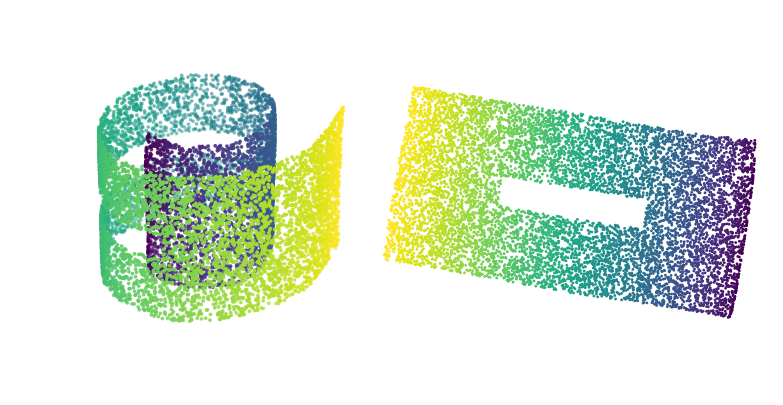

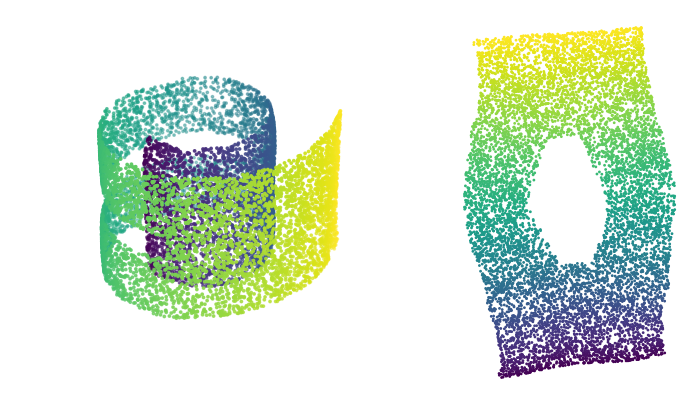

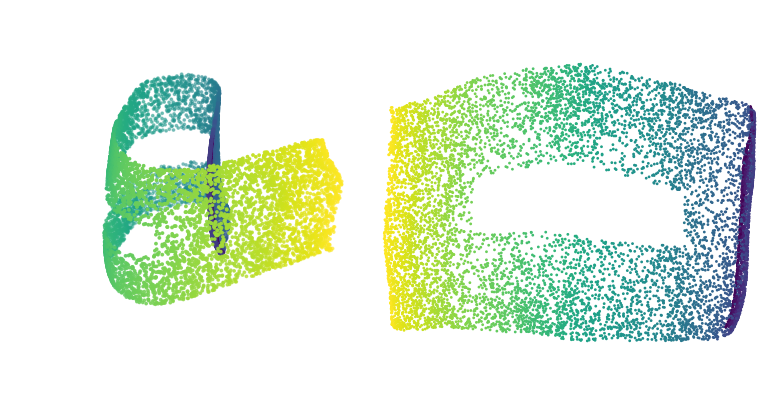

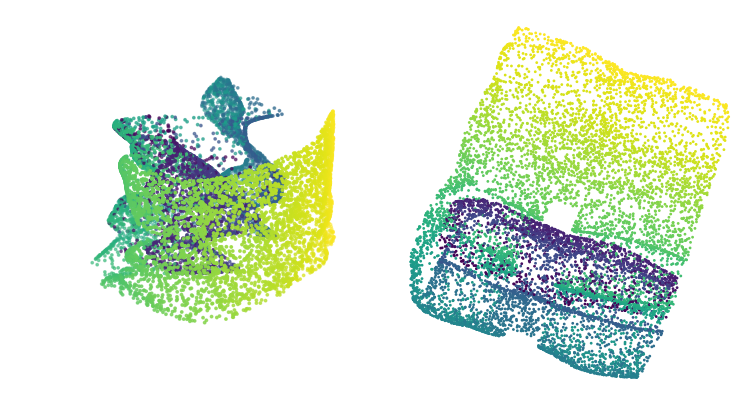

Calculating PHATE...
  Running PHATE on 1500 observations and 3 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.10 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 0.10 seconds.
  Calculating optimal t...
    Automatically selected t = 24
  Calculated optimal t in 0.62 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.13 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.90 seconds.
Calculated PHATE in 1.75 seconds.


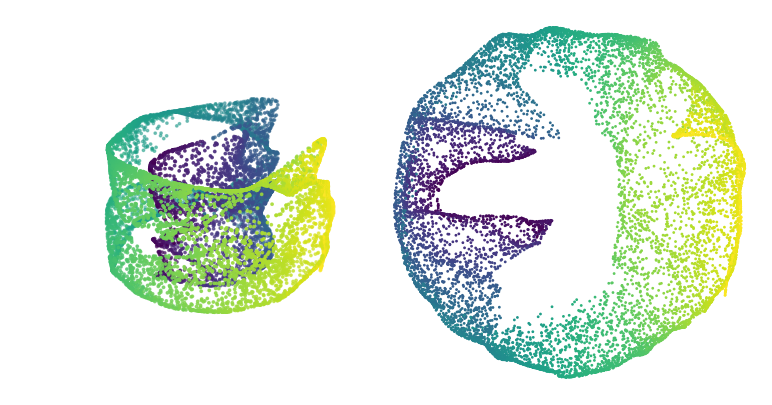

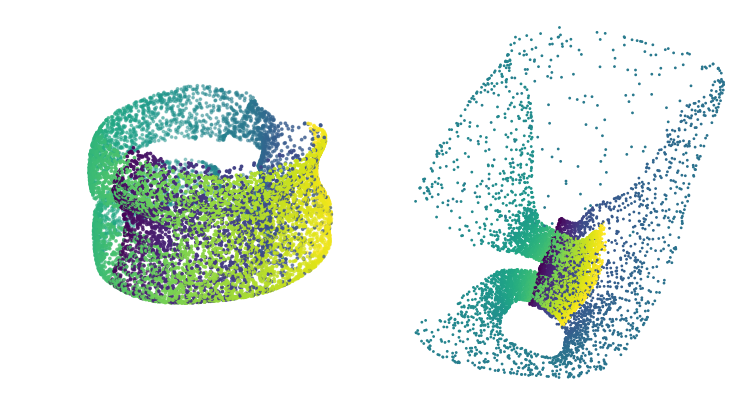

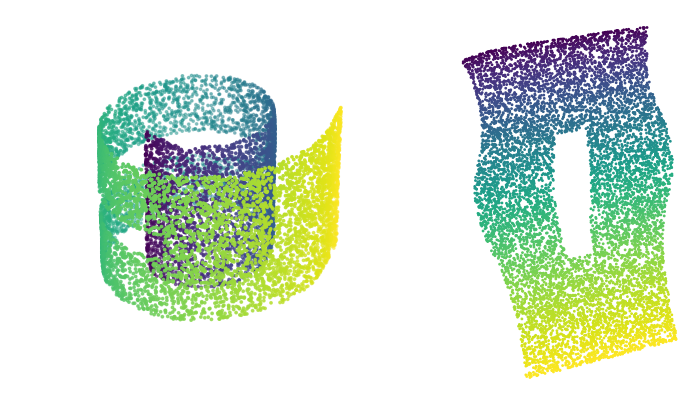

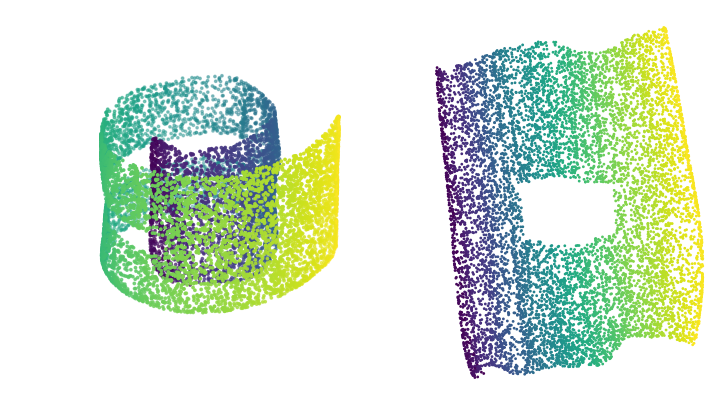

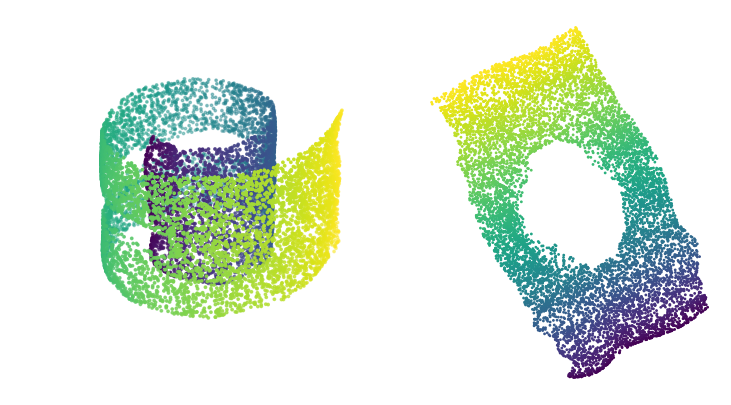

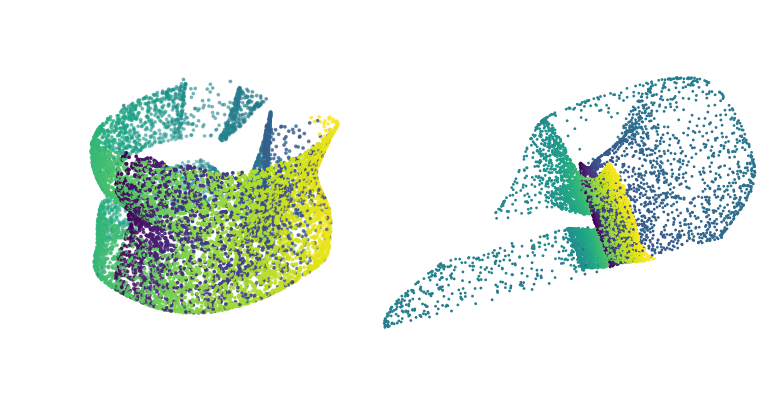

In [6]:
torch.manual_seed(21)
np.random.seed(21)

BLAE = train_BLAE(X_train, y_train, X_test, y_test)
visualizationss(BLAE.to('cpu'), X, y, method_name='BLAE')

SPAE = train_SPAE(X_train, y_train, X_test, y_test)
visualizationss(SPAE.to('cpu'), X, y, method_name='SPAE')

DNAE = train_DNAE(X_train, y_train, X_test, y_test)
visualizationss(DNAE.to('cpu'), X, y, method_name='DNAE')

GGAE = train_GGAE(X_train, y_train, X_test, y_test)
visualizationss(GGAE.to('cpu'), X, y, method_name='GGAE')

GRAE = train_GRAE(X_train, y_train, X_test, y_test)
visualizationss(GRAE.to('cpu'), X, y, method_name='GRAE')

IRAE = train_IRAE(X_train, y_train, X_test, y_test)
visualizationss(IRAE.to('cpu'), X, y, method_name='IRAE')

GeomAE = train_GeomAE(X_train, y_train, X_test, y_test)
visualizationss(GeomAE.to('cpu'), X, y, method_name='GeomAE')

CAE = train_CAE(X_train, y_train, X_test, y_test)
visualizationss(CAE.to('cpu'), X, y, method_name='CAE')

TopAE = train_TopAE(X_train, y_train, X_test, y_test)
visualizationss(TopAE.to('cpu'), X, y, method_name='TopAE')

VAE = train_VAE(X_train, y_train, X_test, y_test)
visualizationss(VAE.to('cpu'), X, y, method_name='VAE')